# Pothole Detection using YOLOv8 on Indian Roads

# 1. Overview

This notebook implements a unified data preparation pipeline for pothole detection using the Road Damage Dataset (RDD 2022).
The same pipeline is used for both India and Japan datasets, ensuring consistency and fair evaluation across regions.

The primary goal of this step is to:

Convert Pascal VOC (XML) annotations into YOLO format

Filter the dataset to focus on D40 pothole class

Create a clean train/validation split ready for YOLOv8 training

# 2. Dataset Description (RDD 2022)

RDD 2022 provides road damage annotations across multiple countries using XML format.

Relevant details:

Annotation format: Pascal VOC (XML)

Image-level bounding boxes

Multiple damage classes (D00, D10, D20, D40, etc.)

**This project focuses exclusively on class D40, which corresponds to potholes, as it is the most relevant for real-world road monitoring systems.**

# 3. Unified Pipeline for India & Japan

This notebook is designed to be **country-agnostic**.
The same data preparation and annotation conversion pipeline is applied to
both the India and Japan subsets of the RDD 2022 dataset.

Only a **single configuration variable** (`COUNTRY`) needs to be updated to
switch between datasets, ensuring consistency, reproducibility, and fair comparison.


# 4. Library Imports
The following libraries are used for file handling, XML parsing, and dataset splitting during annotation conversion.

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# ========== Configuration Parameters =============

BASE_DIR = "."
COUNTRY = "india"      # change to "Japan" to process Japanese dataset

# ===== Defines the dataset root and country-specific folders =====

INPUT_IMG_DIR = f"{BASE_DIR}/{COUNTRY}/images"
INPUT_ANN_DIR = f"{BASE_DIR}/{COUNTRY}/annotations/xmls"

OUTPUT_DIR = "yolo_dataset"
TRAIN_RATIO = 0.8

CLASS_NAME = "D40"
CLASS_ID = 0

# ======== YOLO Directory Structure Creation ==========

os.makedirs(f"{OUTPUT_DIR}/images/train", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/images/val", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/labels/train", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/labels/val", exist_ok=True)

# ======= Annotation File Discovery & Validation ==========

xml_files = [f for f in os.listdir(INPUT_ANN_DIR) if f.endswith(".xml")]

print("Annotation dir:", INPUT_ANN_DIR)
print("Exists:", os.path.exists(INPUT_ANN_DIR))

files = os.listdir(INPUT_ANN_DIR)
print("Total files:", len(files))

xml_files = [f for f in files if f.lower().endswith(".xml")]
print("XML files found:", len(xml_files))

print(xml_files[:5])  # show first 5

# ======= Train/Validation Split =======

train_xmls, val_xmls = train_test_split(
    xml_files, test_size=1-TRAIN_RATIO, random_state=42
)

# ======= XML to YOLO Annotation Conversion Logic =======

def convert(xml_file, split):
    xml_path = os.path.join(INPUT_ANN_DIR, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    img_path = os.path.join(INPUT_IMG_DIR, filename)

    size = root.find("size")
    img_w = int(size.find("width").text)
    img_h = int(size.find("height").text)

    yolo_lines = []

    for obj in root.findall("object"):
        label = obj.find("name").text
        if label != CLASS_NAME:
            continue

        box = obj.find("bndbox")
        xmin = int(box.find("xmin").text)
        ymin = int(box.find("ymin").text)
        xmax = int(box.find("xmax").text)
        ymax = int(box.find("ymax").text)

        x_center = ((xmin + xmax) / 2) / img_w   # ===== Bounding Box Normalization (YOLO Format) =======
        y_center = ((ymin + ymax) / 2) / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_lines.append(
            f"{CLASS_ID} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        )

    # 🔴 Skip images without D40
    if not yolo_lines:
        return

    label_out = os.path.join(
        OUTPUT_DIR, "labels", split, xml_file.replace(".xml", ".txt")        # ===== Save YOLO Annotations and Copy Images =======
    )
    with open(label_out, "w") as f:
        f.write("\n".join(yolo_lines))

    shutil.copy(
        img_path,
        os.path.join(OUTPUT_DIR, "images", split, filename)
    )

# ===== Conversion Execution =====
for xml in train_xmls:
    convert(xml, "train")

for xml in val_xmls:
    convert(xml, "val")

print(f"{COUNTRY.upper()} conversion done (D40 only).")


Annotation dir: ./india/annotations/xmls
Exists: True
Total files: 7706
XML files found: 7706
['India_000000.xml', 'India_000001.xml', 'India_000002.xml', 'India_000003.xml', 'India_000005.xml']
INDIA conversion done (D40 only).


# 5. Dataset Integrity Verification (YOLO Format)

# Purpose

Before proceeding to model training, it is critical to verify that:

Every image has a corresponding label file

The train/validation split is consistent

No annotations were dropped or mismatched during conversion

This step ensures the YOLO dataset structure is valid and error-free.

In [ ]:
# =======Verification Code =======

import os

print("Train images:", len(os.listdir("yolo_dataset/images/train")))
print("Train labels:", len(os.listdir("yolo_dataset/labels/train")))

print("Val images:", len(os.listdir("yolo_dataset/images/val")))
print("Val labels:", len(os.listdir("yolo_dataset/labels/val")))


Train images: 2327
Train labels: 2327
Val images: 593
Val labels: 593


# 6. Visual Verification of YOLO Annotations (Sanity Check)

# Purpose

After converting annotations into YOLO format, it is essential to visually inspect bounding boxes to ensure:

Bounding boxes are correctly positioned

Normalized YOLO coordinates were converted properly

No label corruption occurred during XML → YOLO conversion

This step helps catch silent errors that numeric checks cannot detect.

# Approach

Randomly sample images from the training set

Load corresponding YOLO label files

Convert normalized YOLO coordinates back to pixel coordinates

Overlay bounding boxes on the original images

Display the results for manual inspection

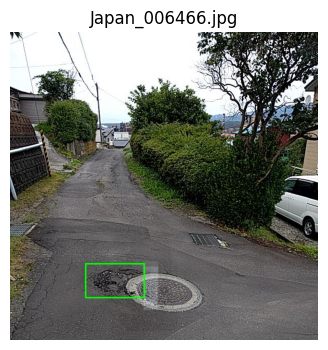

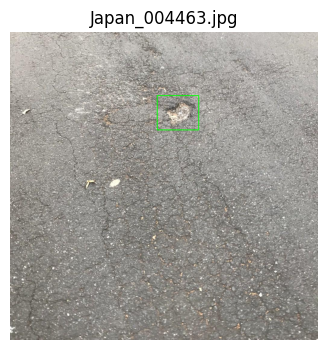

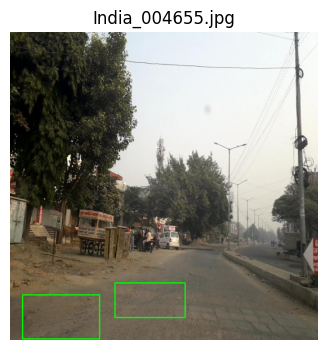

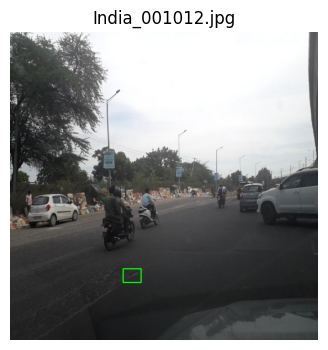

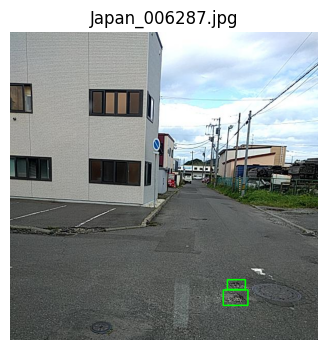

In [ ]:
# ======= Visualization Code =======
import cv2
import os
import random
import matplotlib.pyplot as plt

IMG_DIR = "yolo_dataset/images/train"
LBL_DIR = "yolo_dataset/labels/train"

# ====== Randomly sample 5 training images ======

img_files = random.sample(os.listdir(IMG_DIR), 5)

for img_name in img_files:
    img_path = os.path.join(IMG_DIR, img_name)
    lbl_path = os.path.join(LBL_DIR, img_name.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    h, w, _ = img.shape
# ====== Draw bounding boxes if label file exists ======
    if os.path.exists(lbl_path):
        with open(lbl_path) as f:
            for line in f:
                _, xc, yc, bw, bh = map(float, line.split())
                x1 = int((xc - bw/2) * w)     # ===== Convert YOLO normalized coordinates to pixel coordinates =====
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_name)
    plt.axis("off")
    plt.show()


# 7. YOLOv8 Dataset Configuration Validation (data.yaml)

# Purpose

Before starting YOLOv8 training, it is critical to verify that the dataset configuration file (data.yaml) is:

Correctly formatted

Points to valid train/validation directories

Uses the expected class index-to-name mapping

This step ensures YOLOv8 can locate images, labels, and class definitions without runtime errors.

# data.yaml Structure

The data.yaml file defines:

Dataset root path

Relative paths to training and validation images

Class index mapping used during training

In [ ]:
# ===== Verification Code ======
import yaml, os

with open("yolo_dataset/data.yaml") as f:
    data = yaml.safe_load(f)

print(data)
print("Train path exists:", os.path.exists("yolo_dataset/images/train"))
print("Val path exists:", os.path.exists("yolo_dataset/images/val"))


{'path': 'yolo_dataset', 'train': 'images/train', 'val': 'images/val', 'names': {0: 'pothole'}}
Train path exists: True
Val path exists: True


# 8. Inference Pipeline on Multi-City Road Videos (India)

# Objective

After training the YOLOv8 pothole detection model, we evaluated its real-world performance on unseen road videos collected from multiple Indian cities.

The goal of this stage was to:

Assess baseline inference behavior

Identify false-positive patterns

Apply confidence threshold tuning

Visually validate improvements across diverse urban scenarios

# Test Cities

Inference was conducted on road videos from the following cities:

1. Chandigarh

2. Chennai

3. Patna

4. Vijayawada

Each city presents distinct road conditions and visual noise, making them ideal for robustness evaluation.

# 8.1 Baseline Inference (Low Confidence Threshold)
🔧 Configuration

We first ran inference using a lower confidence threshold (conf ≈ 0.25–0.35) to maximize recall and observe raw model behavior.

Key parameters were kept constant across all cities to ensure fair comparison.

# SET 1: Baseline inference (KEEP SAME PARAMETERS)

# =========== PowerShell Command (Baseline) ========== 

& "C:\Users\KAKASHI\AppData\Local\Programs\Python\Python310\Scripts\yolo.exe" detect predict `
  model=runs/detect/pothole_yolov823/weights/best.pt `
  source=..\pothole_test_data\road_video\chennai\chennai_road.mp4 `
  conf=0.35 `
  imgsz=640 `
  save=True `
  project=..\pothole_test_data\inference_results `
  name=chennai_inference


#  Observed Issues (Baseline)

While the baseline inference detected most pothole-like patterns, it also produced significant false positives, including:

Road lane markers

Repaired road patches

Bike speedometers

Car stereo dashboards

Zebra crossings and road markings

These errors were especially common in urban traffic scenes and dashboard-mounted camera views.

# 8.2 Confidence Threshold Tuning (Proposed)
# Motivation

To reduce false positives and improve prediction reliability, we increased the confidence threshold from baseline values to:

conf = 0.5

This adjustment prioritizes precision over recall, which is more suitable for deployment-oriented applications.

# SET 2: Confidence-tuned inference (AFTER baseline)

# ===== PowerShell Command (Confidence-Tuned) =====

& "C:\Users\KAKASHI\AppData\Local\Programs\Python\Python310\Scripts\yolo.exe" detect predict `
  model=runs/detect/pothole_yolov823/weights/best.pt `
  source=..\pothole_test_data\road_video\patna\patna_road.mp4 `
  conf=0.5 `
  imgsz=640 `
  save=True `
  project=..\pothole_test_data\inference_conf_0.5 `
  name=patna


# 8.3 Organized Inference Outputs

For each city, two separate result folders were generated:

inference_results/ → Baseline predictions

inference_conf_0.5/ → Confidence-tuned predictions

This ensured:

No overwriting of results

Clean side-by-side comparison

Reproducible analysis

# 8.4 Visual Comparison & False-Positive Analysis

# Methodology

To evaluate the impact of confidence threshold tuning on pothole detection performance, a structured visual analysis was conducted across multiple Indian cities.

For each city dataset:

Identical video frames were extracted from dashcam footage

Inference was performed using:

Baseline model (confidence = 0.25)

Tuned model (confidence = 0.5)

Predictions from both configurations were placed side-by-side

Detected bounding boxes were visually inspected

False positives were manually identified and categorized

This process ensures a fair and reproducible comparison by eliminating variations in frame selection and environmental conditions.

# Effect of Confidence Threshold Tuning

Increasing the confidence threshold from 0.25 → 0.5 resulted in:

Significant reduction in false positives

Improved robustness across different road environments

Better suppression of non-pothole structures such as:

Road markings

Vehicle components

Repaired surfaces

Speed breakers

Side-by-side visual comparisons demonstrate that the tuned configuration maintains pothole detection capability while reducing noise.

Reproducibility

All inference runs were executed using the same trained YOLOv8 model

Frame selection was kept identical across configurations

Results are reproducible using the provided notebooks and scripts

# 9. Final Results & Insights

# What Was Achieved:

A unified pothole detection pipeline was built using YOLOv8

Training data was sourced from RDD 2022 (India + Japan) and unified into a single YOLO-compatible dataset

The trained model was evaluated on real-world dashcam videos from:

Chandigarh

Chennai

Patna

Vijayawada

Systematic confidence threshold tuning was applied and analyzed

# Key Observations

Lower confidence thresholds increase false positives
Urban road elements such as lane markings, speed breakers, and repaired patches are visually similar to potholes and are frequently misclassified.

Confidence tuning is a simple but powerful control lever
Adjusting the confidence threshold significantly improves detection quality without retraining the model.

Model generalizes across cities but remains context-sensitive
Each city exhibits unique false-positive patterns based on road design and infrastructure.

Visual evaluation remains critical
Quantitative metrics alone are insufficient — side-by-side visual inspection revealed failure modes not captured by aggregate scores.

# Limitations & Future Improvements

Only a single pothole class (D40) was considered

False positives were manually analyzed (not automatically filtered)

Temporal consistency across frames was not enforced

# Future directions:

Add multi-class road damage detection

Introduce temporal smoothing across video frames

Integrate GPS tagging for map-based pothole reporting

Explore automation using street-level imagery (e.g., Google Street View)